In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import equity_analysis as ea
import portfolio_analysis as pa

In [2]:
data = ea.get_data(["AAPL", "GOOG", "MSFT"], start="2019-01-01", end="2025-01-01")
returns = ea.compute_returns(data)
weight = np.array([1/3,1/3,1/3])
portfolio_returns = returns @ weight

#V = current portfolio dollar value
V = 100000
#Params
confidence = 0.95
alpha = 1 - confidence #tail probability (0.05)
#daily mean and standard deviation
mu = portfolio_returns.mean()
sigma = portfolio_returns.std(ddof=1)
#z for the quantile
z = norm.ppf(alpha)
#return quantile
q = mu + z * sigma
#VaR as a positive dollar loss
VaR_param_percent = -q
VaR_param_dollars = VaR_param_percent * V

print(f"Parametric VaR ({int(confidence*100)}%): {VaR_param_percent:.4%} of portfolio = ${VaR_param_dollars:,.2f}")



/Users/keyansaguibo/PyCharmMiscProject/.venv/quant_projects/equity_analysis.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)["Close"]
[*********************100%***********************]  3 of 3 completed

Parametric VaR (95%): 2.6901% of portfolio = $2,690.13


In [3]:
q_hist = portfolio_returns.quantile(alpha)
VaR_hist_percent = -q_hist
VaR_hist_dollars = VaR_hist_percent * V
print(f"Historical VaR ({int((1-alpha)*100)}%): {VaR_hist_percent:.4%} => ${VaR_hist_dollars:,.2f}")

Historical VaR (95%): 2.6137% => $2,613.72


In [4]:
#monte carlo VaR
#inputs
n_sims = 20000
n_days = 1 #horizons in days

mean_vec = returns.mean().values
cov_mat = returns.cov().values
weights = np.array([1/3,1/3,1/3])

#simulate
sims = np.random.multivariate_normal(mean_vec, cov_mat, size=n_sims)
sim_portfolio_returns = sims.dot(weights)

#find empirical quantile
q_mc = np.quantile(sim_portfolio_returns, alpha)
VaR_mc_percent = -q_mc
VaR_mc_dollars = VaR_mc_percent * V
print(f"Monte Carlo VaR ({int(confidence*100)}%): {VaR_mc_percent:.4%} => ${VaR_mc_dollars:,.2f}")


Monte Carlo VaR (95%): 2.7317% => $2,731.66


In [5]:
#EWMA VaR
lambda_ = 0.94
#compute EWMA variance of portfolio returns
squared = portfolio_returns**2
ewma_var = squared.ewm(alpha=1-lambda_).mean() #gves time serios of variance
current_sigma = np.sqrt(ewma_var.iloc[-1])

#parametric VaR with EWMA sigma
z = norm.ppf(alpha)
q_ewma = mu + z * current_sigma
VaR_ewma = -q_ewma * V
print("EWMA VaR (1-day)", VaR_ewma)


EWMA VaR (1-day) 1845.7699832671367


In [6]:
from scipy.stats import binom
window = 252
VaR_rolling = []

for i in range(window, len(portfolio_returns)):
    window_returns = portfolio_returns.iloc[i-window:i]
    q = window_returns.quantile(alpha)
    VaR_rolling.append(-q)

VaR_rolling = pd.Series(VaR_rolling, index=portfolio_returns.index[window:])

#exceptions
actual_losses = -portfolio_returns[window:]
exceptions = actual_losses > VaR_rolling.values
num_exceptions = exceptions.sum()
T = len(VaR_rolling)
expected = alpha * T

print(f"Exceptions: {num_exceptions}, Expected ~ {expected:.1f} out of {T} days")

p_value = 1 - binom.cdf(num_exceptions - 1, T, alpha)
print("Binomial p-value for observed exceptions:", p_value)

Exceptions: 72, Expected ~ 62.9 out of 1257 days
Binomial p-value for observed exceptions: 0.13233810758583742


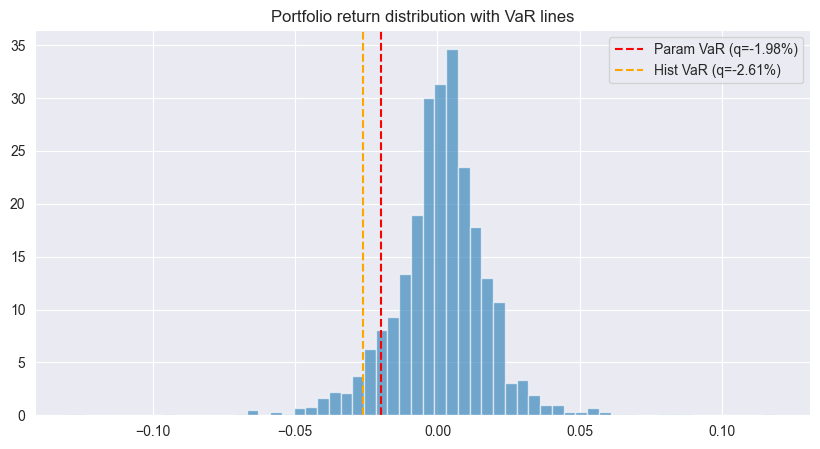

In [7]:

plt.figure(figsize=(10,5))
plt.hist(portfolio_returns, bins=60, density=True, alpha=0.6)
# mark parametric VaR
plt.axvline(x=q, color='r', linestyle='--', label=f'Param VaR (q={q:.2%})')
# mark historical VaR
plt.axvline(x=q_hist, color='orange', linestyle='--', label=f'Hist VaR (q={q_hist:.2%})')
plt.title("Portfolio return distribution with VaR lines")
plt.legend()
plt.show()